# Stochastic contribution analysis for a parameterized foreground system

Pierre Jouannais

If you are studying the uncertain contribution in a foreground system for which you have a model that can simulate the inventory based on different parameters (process simulation etc.).

In [7]:
import bw2data
import bw2io
from bw2data.parameters import *
import brightway2 as bw
import time
import numpy as np
import pandas as pd

I have used Salib to create my sample of parameters, but it can be done without.
Sensitivity analysis can be done at the same time very easily.

In [2]:

from SALib.sample import saltelli
from SALib.sample import fast_sampler
from SALib.analyze import sobol
from SALib.analyze import fast
import SALib

## Loading databases

In [38]:
bw.projects.set_current('chem_paper') 

In [39]:

# Loading Ecoinvent
Ecoinvent = bw.Database('ecoinvent 3.7 conseq')
biosph = bw.Database('biosphere3')


Here I am making a dummy foreground product system for the example.

In [40]:
act1=Ecoinvent.random()
act2=Ecoinvent.random()
act3=Ecoinvent.random()

We don't care about the amounts in the initial foreground as we will modify them according to our own model.

In [41]:
db_contrib_Magic = bw.Database('db_contrib_Magic')
db_contrib_Magic.write({  
    ('db_contrib_Magic', 'magic_prod_for_sa'): {
        'name': 'Magic Prod',
        'unit': 'Magic Unit',
        'exchanges': [{                  
            'input': ('db_contrib_Magic', 'First activity'),   
            'amount': 0.2, 
            'type': 'technosphere'},  
        { 
            'input': ('db_contrib_Magic', 'Second activity'), 
            'amount': 0.2,  
            'type': 'technosphere'},    
 
        { 
            'input':  ('db_contrib_Magic', 'Third activity'), 
            'amount': -0.0000002, 
            'type': 'technosphere'},  

        {
            'input': ('db_contrib_Magic', 'magic_prod_for_sa'),
            'amount': 1.0, 
            'type': 'production'}]
    },
    ('db_contrib_Magic', 'First activity'): {
        'name': 'First activity',
        'unit': 'Strange Unit',
        'exchanges': [{
            'input': act1,  
            'amount': 1,
            'type': 'technosphere'},  
            {'input': ('db_contrib_Magic', 'First activity'),
            'amount': 1.0, 
            'type': 'production'}]},
    
    ('db_contrib_Magic', 'Second activity'): {
        'name': 'Second activity',
        'unit': 'Strange Unit',
        'exchanges': [{
            'input': act2,  
            'amount': 1, 
            'type': 'technosphere'},  
   
        {
            'input': ('db_contrib_Magic', 'Second activity'),
            'amount': 1.0,
            'type': 'production'}]},
    
    ('db_contrib_Magic', 'Third activity'): {
        'name': 'Third activity',
        'unit': 'Strange Unit',
        'exchanges': [{
            'input': act3, 
            'amount': 1, 
            'type': 'technosphere'},  
   
        {
            'input': ('db_contrib_Magic','Third activity'),
            'amount': 1.0, 
            'type': 'production'}]}})

Writing activities to SQLite3 database:
0% [####] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/10/2023 10:06:48
  Finished: 02/10/2023 10:06:48
  Total time elapsed: 00:00:00
  CPU %: 208.30
  Memory %: 1.94


In [42]:
for act in db_contrib_Magic:
    print(act)

'First activity' (Strange Unit, None, None)
'Third activity' (Strange Unit, None, None)
'Second activity' (Strange Unit, None, None)
'Magic Prod' (Magic Unit, None, None)


 We collect the main activity for which we want to assess the contribution of the different inputs.

In [43]:
for act in db_contrib_Magic:
    
    if act['name'] == 'Magic Prod':
        
        Mainprod = db_contrib_Magic.get(act['code'])   


We collect the input activities to our main process and save it as a list of functional units for LCA.

***Important : You first need to "Flatten" your product system. We are assessing the contribution of the activites in THE FIRST LAYER of the product system = the direct inputs to the main activity. There are no emissions associated to the main activity and there are no exchanges between the activities of the first layer.***

In [44]:
list_foreground_technosphere_inputs_FU = []

list_foreground_technosphere_inputs_names = []

for exc in list(Mainprod.exchanges()):

        if exc['type']!='production': # We just want the inputs to the main process
            
            exchange1 = db_contrib_Magic.get(exc['input'][1])   
            
            name_exchange = exchange1['name']  
            
            list_foreground_technosphere_inputs_names.append(name_exchange)
        
            list_foreground_technosphere_inputs_FU.append({exchange1 : 1})
    

In [45]:
# Choose methods

methods_selected = ([
     ('ReCiPe Midpoint (H) V1.13', 'terrestrial ecotoxicity', 'TETPinf'),
     ('ReCiPe Midpoint (H) V1.13', 'climate change', 'GWP100'),
     ('ReCiPe Midpoint (H) V1.13', 'freshwater eutrophication', 'FEP'),
     ('ReCiPe Midpoint (H) V1.13', 'water depletion', 'WDP')])



Calculate impact for each 1 unit of each input and for each method and save it in a dictionnary

In [46]:
my_calculation_setup = {'inv': list_foreground_technosphere_inputs_FU, 'ia': methods_selected}

bw.calculation_setups['technosphere_inputs'] = my_calculation_setup



# Calculating the impacts for all chosen methods

mlca_techno = bw.MultiLCA('technosphere_inputs')  

res = mlca_techno.results

dict_mono_technosphere_lcas = { name : results for (name, results) in zip(list_foreground_technosphere_inputs_names,res) }






In [47]:
dict_mono_technosphere_lcas

{'First activity': array([8.53916559e-09, 1.76783142e-04, 1.49268103e-07, 1.81058516e-06]),
 'Second activity': array([1.38193732e-01, 1.36160103e+03, 6.75945070e-01, 7.74055306e+00]),
 'Third activity': array([1.52917978e-02, 7.49274521e-01, 2.72630380e-04, 5.07151895e-02])}

In [48]:

# Each flow has the same name as the corresponding activity in the original database

names_act = ['First activity','Second activity','Third activity']


# Assigning each process to a a broader category for contribution analysis if needed

# Names of categories

categories_contribution = ['Thermoregulation','Cleaning']


# List of processes to assign to categories (same order)

processes_in_categories = [['First activity', 'Second activity'],  # First and second acitivites belong to "Thermoregulation"
                           ['Third activity']] # Third Activity is alone in "Cleaning"






There are 2 uncertain parameters in our model and we assume normal distributions for them

In [49]:
names_param = ["param1","param2"] 
bounds = [[5,0.2],[3,0.8]]
dists=["norm","norm"]
size=30

We generate the stochastic sample with Salib but it's not necessary

In [50]:
problem = {'num_vars': len(names_param),  # number of variables
           'names': names_param,  
           'bounds': bounds,
           'dists': dists}

30 Montecarlo iterations

In [51]:
sample = SALib.sample.saltelli.sample(problem,
                                          size,
                                          calc_second_order=False)

C:\Users\YJ50DK\Miniconda3\envs\bw2\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (30) is equal to `2^n`.
        
  warnings.warn(msg)


In [52]:
sample

array([[4.66481206, 2.49912079],
       [5.10668194, 2.49912079],
       [4.66481206, 3.0942159 ],
       [5.10668194, 3.0942159 ],
       [5.02355397, 3.57961151],
       [4.83389782, 3.57961151],
       [5.02355397, 1.65924822],
       [4.83389782, 1.65924822],
       [5.16610218, 1.27690024],
       [5.33518794, 1.27690024],
       [5.16610218, 3.6644087 ],
       [5.33518794, 3.6644087 ],
       [4.89331806, 3.03134087],
       [4.97644603, 3.03134087],
       [4.89331806, 2.57327224],
       [4.97644603, 2.57327224],
       [4.96058018, 2.13798755],
       [4.71644057, 2.13798755],
       [4.96058018, 2.84232073],
       [4.71644057, 2.84232073],
       [5.28355943, 3.28810391],
       [5.03941982, 3.28810391],
       [5.28355943, 4.13423771],
       [5.03941982, 4.13423771],
       [5.0890193 , 2.77784765],
       [4.9109807 , 2.77784765],
       [5.0890193 , 2.24257459],
       [4.9109807 , 2.24257459],
       [4.81064365, 3.98388701],
       [5.18935635, 3.98388701],
       [4.

The foreground inventory (amounts of first, second and third activities) is calculated based on a model of some type (Process simulation, aspen, anything)


The function calculate_inputs stands as a dummy model to simulate an LCI

In [69]:
def calculate_inputs(param1,param2): 
    
    input1 = param1*2000/(1+param2)  # Just dummy relationships between parameters and amounts of inputs
    input2 = param2/param1*2
    input3 = 3000*input2/input1
    
    return([input1,input2,input3])

## Calculate everything

Initialize the lists and tables that will collect the results.

In [70]:
results_table = np.empty((0,
                          len(names_param)+len(names_act) + len(methods_selected)),
                         dtype=float)


# list of tables whih will contain the conribution of each process category to each impact category

# There are the same. I will just calculate contributions in two different ways
list_tables_contribution = [np.zeros((len(sample),
                                      len(categories_contribution)),
                                     dtype=float) for i in range(len(methods_selected))]  

list_tables_contribution_abs = [np.zeros((len(sample),
                                      len(categories_contribution)),
                                     dtype=float) for i in range(len(methods_selected))]  

In [71]:
count = -1 # an index to put the results in the right position

for rowparam in sample: # We browse the stochastic sample of parameters.
    
    # rowparam is a set of parameters
    count += 1
    
    LCI_collected = calculate_inputs(rowparam[0],rowparam[1]) # Collect output of the model which calculates the LCI
    
    LCIdict_collected = {a: i for a,i in zip(names_act,LCI_collected)} # Put it in a dictionnary with the names of the activities as keys

    dict_mono_technosphere_impacts = dict_mono_technosphere_lcas.copy() # I just want to keep the structure so I make a copy
    
    for i in dict_mono_technosphere_lcas: # Impact associated with an input = amount of this input * impact for 1 unit of this input 
            
        dict_mono_technosphere_impacts[i]=[LCIdict_collected[i]*a for a in dict_mono_technosphere_lcas[i]] # Done for all the methods at the same time
    
    
    # Calculating total impact by summing
        
    list_LCA_res =[]  # Will contain total impact for the main activity, for all the methods 

    for meth_index in range(len(methods_selected)):

        sum_impact = sum([dict_mono_technosphere_impacts[flow][meth_index] for flow in dict_mono_technosphere_impacts ])


        list_LCA_res.append(sum_impact)
  

    # The row I will add to the final result
    row_to_add = list(rowparam) + LCI_collected  + list_LCA_res 

    # Adding this new row

    results_table = np.vstack((results_table, row_to_add))  

    names_methods_adjusted = [a[-1] for a in methods_selected]

    names_for_df = names_param+names_act + names_methods_adjusted

    results_table_df = pd.DataFrame(results_table, columns=names_for_df)


    # Contribution per process category
    for process in dict_mono_technosphere_impacts :

        # browsing the categories
        for index_content_categ in range(len(processes_in_categories)):


            # if this process belongs to category
            if process in processes_in_categories[index_content_categ]:

                # Then we add this value to the corresponding colum in the  list_tables_contribution
                for meth_index in range(len(methods_selected)): #we do this for all methods 

                    list_tables_contribution[meth_index][count, index_content_categ] = (
                        list_tables_contribution[meth_index][count, index_content_categ] 
                        + dict_mono_technosphere_impacts[process][meth_index])


results_table_df contains the parameters values, the corresponding amounts of inputs, and the total impact for the activity

In [72]:
results_table_df

,param1,param2,First activity,Second activity,Third activity,TETPinf,GWP100,FEP,WDP
0,4.664812,2.499121,2666.276665,1.071478,1.205589,0.166530,1460.299656,0.724987,8.359798
1,5.106682,2.499121,2918.837187,0.978765,1.005981,0.150667,1333.957193,0.662301,7.632486
2,4.664812,3.094216,2278.732812,1.326620,1.746523,0.210057,1808.038278,0.897538,10.361472
3,5.106682,3.094216,2494.583611,1.211830,1.457354,0.189774,1651.562309,0.819900,9.458663
4,5.023554,3.579612,2193.877785,1.425131,1.948784,0.226763,1942.307986,0.964169,11.134108
...,...,...,...,...,...,...,...,...,...
115,5.055538,3.426728,2284.097128,1.355633,1.780528,0.214587,1847.569519,0.917160,10.587786
116,5.144903,3.094216,2513.254309,1.202828,1.435781,0.188200,1639.291554,0.813812,9.387918
117,4.754028,3.094216,2322.314389,1.301724,1.681586,0.205624,1774.099001,0.880699,10.165549
118,5.144903,2.335591,3084.852080,0.907924,0.882951,0.138998,1237.437648,0.614408,7.078201


Now we calculate the contributions based 

In [73]:

#Calulating contribution sum
for index_method in range(len(methods_selected)):

    for index_row in range(len(sample)):

        sumrow = np.sum(list_tables_contribution[index_method][index_row])

        sumrow_abs = sum([abs(a) for a in list_tables_contribution[index_method][index_row,:]]) # Here I calculate the contribution based on the absolute values because I think it makes more sense when you can have postitive and negative numbers 

        for index_col in range(len(categories_contribution)):

            list_tables_contribution_abs[index_method][index_row][index_col] =(
                list_tables_contribution[index_method][index_row][index_col]
                *100/sumrow_abs)

            list_tables_contribution[index_method][index_row][index_col] =(
                list_tables_contribution[index_method][index_row][index_col]
                *100/sumrow)



#  Conversion to Dataframes
list_tables_contribution_df = [pd.DataFrame(
    table, columns=categories_contribution) for table in list_tables_contribution]

list_tables_contribution_abs_df=[pd.DataFrame(
    table, columns=categories_contribution) for table in list_tables_contribution_abs]



In [74]:
list_tables_contribution_abs_df # A list of tables of contributions for all MC iterations. 1 table per impact category.

[     Thermoregulation   Cleaning
 0           88.929543  11.070457
 1           89.789920  10.210080
 2           87.285634  12.714366
 3           88.256803  11.743197
 4           86.858366  13.141634
 ..                ...        ...
 115         87.311683  12.688317
 116         88.333884  11.666116
 117         87.494443  12.505557
 118         90.286237   9.713763
 119         89.570582  10.429418
 
 [120 rows x 2 columns],
      Thermoregulation  Cleaning
 0           99.938142  0.061858
 1           99.943495  0.056505
 2           99.927622  0.072378
 3           99.933883  0.066117
 4           99.924823  0.075177
 ..                ...       ...
 115         99.927791  0.072209
 116         99.934374  0.065626
 117         99.928980  0.071020
 118         99.946537  0.053463
 119         99.942140  0.057860
 
 [120 rows x 2 columns],
      Thermoregulation  Cleaning
 0           99.954664  0.045336
 1           99.958590  0.041410
 2           99.946949  0.053051
 3        

In [75]:
list_tables_contribution_abs_df[0]

,Thermoregulation,Cleaning
0,88.929543,11.070457
1,89.789920,10.210080
2,87.285634,12.714366
3,88.256803,11.743197
4,86.858366,13.141634
...,...,...
115,87.311683,12.688317
116,88.333884,11.666116
117,87.494443,12.505557
118,90.286237,9.713763


The following distribution is the result of the example model and random activities, therefore the distributions may not look very interesting...

<AxesSubplot:ylabel='Density'>

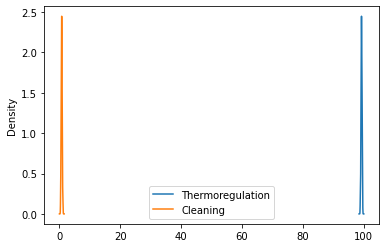

In [76]:
list_tables_contribution_abs_df[3].plot.kde()  # The fourth impact category. Feel free to plot something better than this.